<a href="https://colab.research.google.com/github/MarcoMosconi/News-Article-Categorization/blob/main/News_Article_Categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Necessary packages

In [ ]:
! pip install transformers torch scikit-learn datasets
! pip install accelerate -U

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import os
import shutil
import pandas as pd
import numpy as np
import random
import torch
from transformers import TrainingArguments, Trainer, DistilBertTokenizer, DistilBertForSequenceClassification, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from datasets import Dataset
from sklearn.metrics import accuracy_score, confusion_matrix

### Load dataset

In [ ]:
df = pd.read_csv("news_article_categorization.csv")
df.head()

,Text,Category
0,"Elon Musk, Amber Heard Something's Fishy On Wr...",Entertainment
1,Scientists are developing more than 100 corona...,science
2,Jared Fogle Shut Down By Judge In Bid for Earl...,Entertainment
3,The agency had come under fire from members of...,Health
4,"Credit...Jim Wilson/The New York TimesJune 30,...",Politics


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3722 entries, 0 to 3721
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      3722 non-null   object
 1   Category  3722 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB


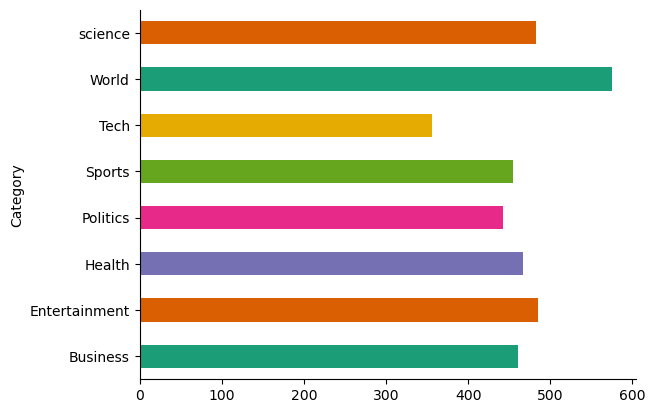

In [ ]:
df.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
count_science = 0
count_others = 0
for i, category in enumerate(df['Category']):
  if category in df['Text'][i:i+1][i].split(' ',1)[0].lower():
    if category == 'science':
        count_science += 1
    else:
        count_others += 1
print(f'There are {count_science} science articles starting with \'science\' and other {count_others} articles starting with their category name')
count_science = df['Category'].value_counts().get('science',0)
print(f'There are {count_science} science articles')

There are 92 science articles starting with 'science' and other 0 articles starting with their category name
There are 482 science articles


It's not a bid deal, since just 92 out of 3722 articles start with their category's name. They are all science articles, but it's $\sim \frac15$ of the total, hence we don't think it is necessary to discard the first word ('science').  

### Encode labels

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Category'])
id2label= dict(sorted(zip(map(int, label_encoder.transform(df['Category'])), df['Category'])))
label2id = dict(sorted(id2label.items(), reverse=True))
print(id2label, label2id)

{0: 'Business', 1: 'Entertainment', 2: 'Health', 3: 'Politics', 4: 'Sports', 5: 'Tech', 6: 'World', 7: 'science'} {7: 'science', 6: 'World', 5: 'Tech', 4: 'Sports', 3: 'Politics', 2: 'Health', 1: 'Entertainment', 0: 'Business'}


In [ ]:
df.pop('Category')
df.head()

,Text,label
0,"Elon Musk, Amber Heard Something's Fishy On Wr...",1
1,Scientists are developing more than 100 corona...,7
2,Jared Fogle Shut Down By Judge In Bid for Earl...,1
3,The agency had come under fire from members of...,2
4,"Credit...Jim Wilson/The New York TimesJune 30,...",3


### Convert to Hugginface dataset

In [ ]:
dt = Dataset.from_dict(df)
dt

Dataset({
    features: ['Text', 'label'],
    num_rows: 3722
})

### Train-validation-test split

In [ ]:
data = dt.train_test_split(test_size=0.2, shuffle=True)
train_and_val = data['train'].train_test_split(test_size=0.2)
data['val'] = train_and_val['test']
data['train'] = train_and_val['train']
data

DatasetDict({
    train: Dataset({
        features: ['Text', 'label'],
        num_rows: 2381
    })
    test: Dataset({
        features: ['Text', 'label'],
        num_rows: 745
    })
    val: Dataset({
        features: ['Text', 'label'],
        num_rows: 596
    })
})

### Tokenization

In [ ]:
model_name='distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
def tokenize_function(data):
  return tokenizer(data['Text'], padding=True, truncation=True)

data_encoded = data.map(tokenize_function, batched=True, batch_size=None)

Map:   0%|          | 0/2381 [00:00<?, ? examples/s]

Map:   0%|          | 0/745 [00:00<?, ? examples/s]

Map:   0%|          | 0/596 [00:00<?, ? examples/s]

### Load model

In [ ]:
print(id2label, label2id)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=8, id2label=id2label, label2id=label2id)

{0: 'Business', 1: 'Entertainment', 2: 'Health', 3: 'Politics', 4: 'Sports', 5: 'Tech', 6: 'World', 7: 'science'} {7: 'science', 6: 'World', 5: 'Tech', 4: 'Sports', 3: 'Politics', 2: 'Health', 1: 'Entertainment', 0: 'Business'}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True
    else:
        print(name)

pre_classifier.weight
pre_classifier.bias
classifier.weight
classifier.bias


In [ ]:
def get_accuracy(preds):
  preds_preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
  predictions = preds_preds.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds_preds.argmax(axis=-1))
  return {'accuracy': accuracy}

In [ ]:
output_dir = './results-news'
os.makedirs(output_dir, exist_ok=True)
for filename in os.listdir(output_dir):
    file_path = os.path.join(output_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

batch_size=16
training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate = 1e-4,
    num_train_epochs = 4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False,
    logging_steps=len(data_encoded['train'])//batch_size,
)

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=data_encoded['train'],
                  eval_dataset=data_encoded['val'],
                  tokenizer=tokenizer,
                 )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.607600,0.232159,0.941275
2,0.164100,0.198493,0.949664
3,0.092300,0.193206,0.954698
4,0.042700,0.178118,0.958054


TrainOutput(global_step=596, training_loss=0.22536263654896077, metrics={'train_runtime': 448.3756, 'train_samples_per_second': 21.241, 'train_steps_per_second': 1.329, 'total_flos': 1261754499956736.0, 'train_loss': 0.22536263654896077, 'epoch': 4.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.17811816930770874,
 'eval_accuracy': 0.9580536912751678,
 'eval_runtime': 8.7773,
 'eval_samples_per_second': 67.902,
 'eval_steps_per_second': 4.329,
 'epoch': 4.0}

In [ ]:
predictions_train = trainer.predict(data_encoded['train'])
print(predictions_train)
print(predictions_train.metrics)

PredictionOutput(predictions=array([[ 6.207222  , -1.4608359 , -0.82252   , ..., -1.3874391 ,
        -1.1831079 , -0.62916386],
       [-1.7947028 , -2.1481948 , -0.13052326, ..., -1.717454  ,
        -1.0710604 ,  6.9058137 ],
       [-1.5227726 ,  7.8060164 , -1.4623762 , ..., -1.5138278 ,
        -1.5940322 , -1.2098466 ],
       ...,
       [-1.6105145 , -1.7068608 , -1.4413645 , ..., -0.9737652 ,
        -0.61094576, -1.2337989 ],
       [-2.002589  , -1.5321802 , -1.8055894 , ..., -0.58501524,
        -1.4017994 , -0.9274596 ],
       [-1.5116707 ,  7.8186617 , -1.4497803 , ..., -1.5147406 ,
        -1.5673115 , -1.2112027 ]], dtype=float32), label_ids=array([0, 7, 1, ..., 3, 4, 1]), metrics={'test_loss': 0.0274382121860981, 'test_accuracy': 0.9928601427971441, 'test_runtime': 35.283, 'test_samples_per_second': 67.483, 'test_steps_per_second': 4.223})
{'test_loss': 0.0274382121860981, 'test_accuracy': 0.9928601427971441, 'test_runtime': 35.283, 'test_samples_per_second': 67.483,

In [ ]:
print(predictions_train[0][0], predictions_train[1][0])

[ 6.207222   -1.4608359  -0.82252    -0.79574245 -1.4600769  -1.3874391
 -1.1831079  -0.62916386] 0


In [ ]:
pred_train_class = predictions_train.predictions.argmax(axis=1)
print(pred_train_class)
label_train=predictions_train.label_ids
print(label_train)

[0 7 1 ... 3 4 1]
[0 7 1 ... 3 4 1]


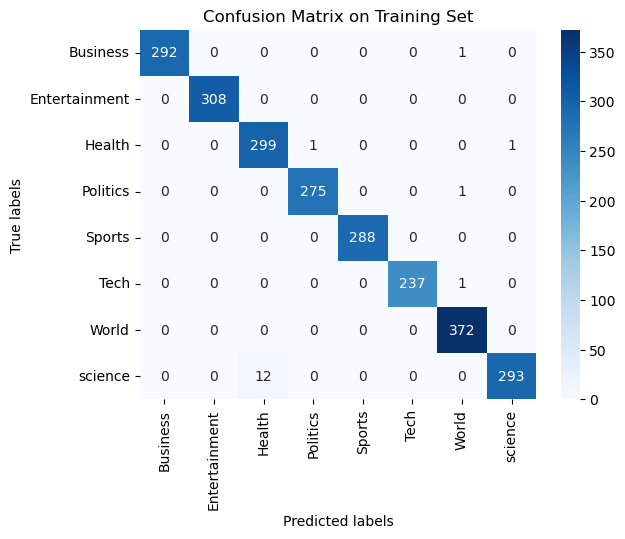

In [ ]:
cm1 = confusion_matrix(label_train, pred_train_class)
labels = [id2label[i] for i in range(len(id2label))]
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Training Set')
plt.show()

In [ ]:
predictions_test = trainer.predict(data_encoded['test'])
print(predictions_test)
print(predictions_test.metrics)

PredictionOutput(predictions=array([[-1.6346657 ,  7.7802863 , -1.4798856 , ..., -1.509297  ,
        -1.618943  , -1.1909059 ],
       [ 7.2262816 , -1.8413042 , -1.2617551 , ...,  0.2245884 ,
        -1.4768791 , -0.8260253 ],
       [-0.84844065, -1.5411117 , -1.9178643 , ...,  7.2070265 ,
        -1.0715758 , -0.8656683 ],
       ...,
       [-1.6491663 , -1.7844393 , -1.4627217 , ..., -0.93007106,
        -0.4073258 , -1.2767721 ],
       [-1.5146159 ,  7.8020644 , -1.4846809 , ..., -1.571223  ,
        -1.5482548 , -1.2158841 ],
       [-1.7483487 , -2.1742368 ,  0.20388699, ..., -1.8273462 ,
        -1.1462331 ,  6.9560184 ]], dtype=float32), label_ids=array([1, 0, 5, 7, 6, 7, 4, 4, 7, 6, 5, 0, 5, 6, 2, 6, 5, 2, 3, 1, 3, 7,
       4, 7, 2, 5, 1, 6, 1, 3, 3, 2, 7, 4, 4, 0, 7, 4, 6, 0, 0, 1, 7, 6,
       3, 4, 1, 5, 3, 0, 6, 1, 1, 4, 5, 3, 0, 3, 6, 7, 2, 6, 6, 2, 4, 2,
       2, 5, 6, 4, 5, 7, 7, 3, 1, 0, 4, 5, 3, 2, 3, 6, 0, 1, 3, 4, 0, 6,
       1, 3, 0, 2, 0, 4, 1, 5, 4, 5, 0, 

In [ ]:
print(predictions_test[0][0], predictions_test[1][0])


[-1.6346657   7.7802863  -1.4798856  -0.7649606  -0.92637324 -1.509297
 -1.618943   -1.1909059 ] 1


In [ ]:
pred_test_class = predictions_test.predictions.argmax(axis=1)
print(pred_test_class)
label_test = predictions_test.label_ids
print(label_test)

[1 0 5 7 6 7 4 4 7 6 5 0 5 6 2 6 5 2 3 1 3 2 4 7 2 7 1 3 1 3 3 2 7 4 4 0 7
 4 6 0 0 1 7 6 3 4 1 5 3 0 6 1 1 4 5 3 0 3 7 7 2 6 6 2 4 2 2 7 6 4 5 7 7 3
 1 0 4 5 3 2 3 6 0 1 3 4 0 6 1 3 0 2 0 4 1 5 4 5 0 7 6 7 6 0 1 0 6 3 1 1 3
 4 2 0 2 7 4 2 7 5 4 3 7 6 3 6 1 4 5 2 2 5 1 0 0 1 7 3 1 3 1 2 2 6 0 6 4 0
 6 1 3 2 3 3 7 0 2 4 1 0 2 5 2 4 4 1 0 3 5 1 1 5 6 6 6 7 5 4 1 2 4 2 1 0 5
 7 1 4 2 0 1 5 1 6 3 6 2 0 6 2 5 2 3 4 2 5 3 0 3 7 2 4 5 7 1 6 5 4 4 1 0 4
 1 0 5 6 7 4 6 1 3 7 4 2 5 6 7 1 2 2 6 1 6 0 4 2 2 5 6 6 0 6 3 0 5 4 2 0 6
 1 1 6 5 7 1 4 5 0 1 5 7 3 3 4 2 4 3 3 1 5 2 0 6 4 2 0 6 0 3 4 3 1 6 6 7 6
 0 0 3 0 5 6 4 7 2 3 4 6 3 0 0 4 6 7 6 6 4 6 7 2 3 3 2 4 5 1 6 3 4 4 1 4 4
 3 0 1 1 5 4 4 6 0 7 3 5 3 7 7 2 2 1 7 2 3 0 5 4 5 3 7 2 4 2 2 6 7 4 6 0 3
 5 5 0 5 0 7 2 4 2 6 6 5 6 6 2 6 6 0 3 4 4 3 3 0 1 2 1 6 2 3 3 3 0 0 1 5 0
 7 3 3 1 4 1 1 1 0 0 0 1 1 6 1 6 4 4 6 2 7 4 5 0 5 2 7 6 7 7 3 0 7 2 3 2 0
 2 4 3 2 4 3 1 7 0 1 7 2 7 1 7 2 4 1 4 5 3 6 6 1 5 6 4 3 0 6 4 1 1 6 4 7 0
 3 2 1 7 0 7 6 3 2 3 2 1 

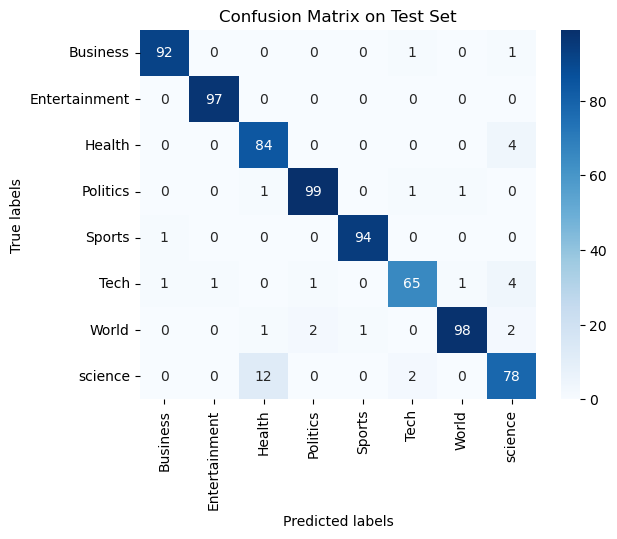

In [ ]:
cm2 = confusion_matrix(label_test, pred_test_class)
labels = [id2label[i] for i in range(len(id2label))]
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Test Set')
plt.show()

We can see how both in train and test set the category where the model struggles the most is science, since it tends to get confused with Health articles. For the rest of the topics the model's almost perfect.